In [44]:
# Import modules
import numpy as np
from qiskit import(
    QuantumCircuit,
    execute,
    Aer,
    QuantumRegister,
    ClassicalRegister
    )

from qiskit.visualization import plot_histogram

In [45]:
# Define our registers and circuit
qb = QuantumRegister(5, 'code_qubit')     # The 5 qubits to encode the state in
an = QuantumRegister(4, 'ancilla_qubit')  # The two ancilla qubits (one of them is unused)
cr = ClassicalRegister(4, 'syndrome_bit') # Classical register for registering the syndromes
readout = ClassicalRegister(5, 'readout') # Readout of the final state at the end for statistics

In [46]:
# Note that some gates might be redundant, haven't checked
def encode_input( circuit, qbReg ):
    '''Encode the input into logical 0 and 1
    This assumes that the 0:th qubit is the
    original state |psi> = a|0> + b|1>'''
    
    circuit.h( qbReg[3] )
    circuit.cz( qbReg[3], qbReg[1] )
    circuit.cz( qbReg[3], qbReg[2] )
    circuit.cx( qbReg[3], qbReg[0] )   

    circuit.h( qbReg[2] )
    circuit.cx( qbReg[2], qbReg[0] )
    circuit.cz( qbReg[2], qbReg[3] )
    circuit.cz( qbReg[2], qbReg[4] )
    
    circuit.h( qbReg[1] )
    circuit.cz( qbReg[1], qbReg[0] )
    circuit.cx( qbReg[1], qbReg[3] )
    circuit.cz( qbReg[1], qbReg[4] )
    
    circuit.h( qbReg[4] )
    circuit.cz( qbReg[4], qbReg[2] )
    circuit.cz( qbReg[4], qbReg[3] )
    circuit.cx( qbReg[4], qbReg[1] )
    
    return

# Define our stabilizers
def measure_stabilizer( circuit, qbReg, anReg, clReg, i ):
    '''Function for adding stabilizer measurements to a circuit.
    Note that a measurement of X is done by using Hadamard before
    and after. Input i specifies the stabilizer to measure:
        i=0: XZZXI
        i=1: IXZZX
        i=2: XIXZZ
        i=3: ZXIXZ
    Other inputs are the circuit as well as the required registers'''
    
    if not isinstance(i, int):
        raise error('i must be an integer')
    
    # Generate indexes
    index = np.mod( i + np.array([0, 1, 2, 3]), 5 ) 
    
    # Measure stabilizers
    circuit.h( qbReg[ index[0] ] )
    circuit.cx( qbReg[ index[0] ], anReg[i] )
    circuit.h( qbReg[ index[0] ] ) 
        
    circuit.cx( qbReg[ index[1] ], anReg[i] )
        
    circuit.cx( qbReg[ index[2] ], anReg[i] )
        
    circuit.h( qbReg[ index[3] ] )
    circuit.cx( qbReg[ index[3] ], anReg[i] )
    circuit.h( qbReg[ index[3] ])
        
    circuit.measure( anReg[i], clReg[i])
    
    return
    


{'00001 0000': 65, '10000 0000': 76, '10011 0000': 82, '10101 0000': 62, '10110 0000': 73, '11001 0000': 78, '11010 0000': 58, '11100 0000': 63, '11111 0000': 57, '00010 0000': 49, '00100 0000': 62, '00111 0000': 55, '01000 0000': 72, '01011 0000': 56, '01101 0000': 63, '01110 0000': 53}


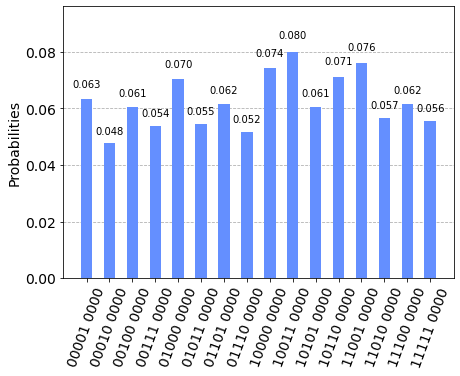

In [48]:
circuit = QuantumCircuit( cr, readout, an, qb )

# Prepare the input
circuit.x( qb[0] ) # As an example, start in |1>

# Encode the state
encode_input( circuit, qb ) 

# Add errors manually
# (Nothing tried here yet)

# Measure stabilizers
measure_stabilizer( circuit, qb, an, cr, 0 )
measure_stabilizer( circuit, qb, an, cr, 1 )
measure_stabilizer( circuit, qb, an, cr, 2 )
measure_stabilizer( circuit, qb, an, cr, 3 )

# Readout of the encoded state
circuit.measure( qb, readout )

counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)

circuit.draw(output='mpl') # If it does not work, simply remove mpl: circuit.draw()
plot_histogram(counts)
# All stabilizers should give 0 (meaning '0000' for all states) unless error has been added.